# Lab 3: Time Series Intro

### Are we headed for a recession?

This code snippet is for data manipulation and visualization of time series data. It does not provide any direct predictive models for recession. However, the time series data used in the code, such as the yield curve data, can be used as one of the inputs for predictive models for recession.

In general, predicting a recession is a complex task that requires a comprehensive analysis of various economic indicators, such as GDP growth, unemployment rate, inflation rate, and consumer spending, among others. Time series analysis is one of the many tools that can be used to analyze and understand the patterns and trends in these economic indicators over time.

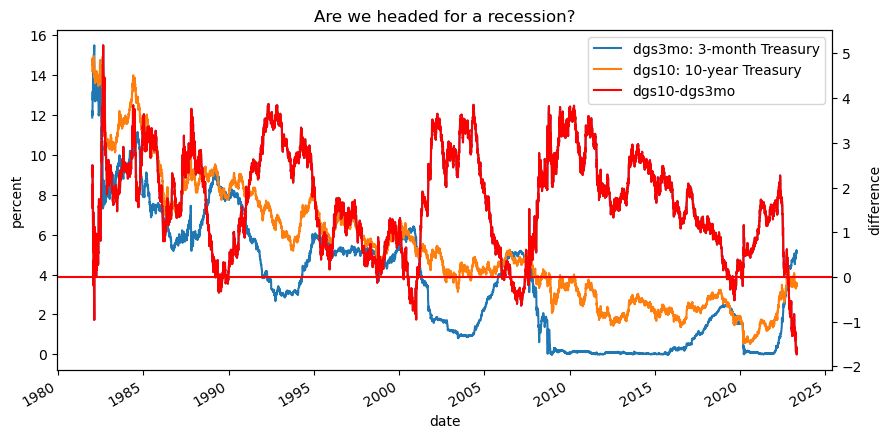

In [23]:
"""Seattle University, OMSBA 5062, Lab3 - Time Series Intro, Jomaica Lei

Classes:
TimeSeries - class to hold a date/value series of data
Difference - a time series that is the difference between two other time series
Fred - a time series that is based on a csv file downloaded from fred.stlouis.org
dgs3mo - the 3-month treasury series from FRED
dgs10 - the 10-year treasury series from FRED

Functions:
recession_visual - plots a graphic visual showing the inverted yield curve
"""

import os
import csv
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt

DATA = '/Users/jomaicaalfiler/Desktop/MSBA/Python - 5062/Week 6/Lab3/'


class TimeSeries(object):
    """Holds a date/value series of data"""
    def __init__(self, name, title=None, unit=None, data=None):
        self.name = name
        self.title = title if title is not None else name
        self.unit = unit
        self.data = data if data is not None else {}
        self.first_date = None if len(self.data) == 0 else min(self.data)
        self.last_date = None if len(self.data) == 0 else max(self.data)

    def get_dates(self, candidates=None, start=None, end=None):
        """Get the dates where this series has values
        ts.get_dates() - gets all dates where ts has values
        ts.get_dates(start=d1,end=d2) - get all valid dates, d, 
                                        where d1<=d<=d2
        ts.get_dates(candidates=dates) - get all valid dates, d, 
                                         for d in dates
        :param candidates: if set, start and end are ignored, and 
                           returns the subset of dates within 
                           candidates that for which this series has data
        :param start:      minimum starting date of returned dates, 
                           defaults to beginning of this series
        :param end:        max ending date of returned dates, 
                           defaults to end of this series
        :return:           a list of dates in order for which
                           this series has values and that satisfy
                           the parameters' conditions
        """
        if candidates is not None:
            return [date for date in candidates if date in self.data]  
        if start is None:
            start = self.first_date
        if end is None:
            end = self.last_date
        return [date for date in sorted(self.data) if start <= date <= end]  
        
    def get_values(self, dates):
        """method that returns a list of values for the given dates 
        (it assumes that the dates are valid)
        """
        ret = []
        for d in dates:
            ret.append(self.data[d])
        return ret

        
    def __sub__(self, other):
        """create a difference time series"""
        return Difference(self, other)
    
    
class Fred(TimeSeries):
    """A time series that is based on a csv file downloaded from
    fred.stlouis.org
    """

    def __init__(self, name, title=None, unit=None, data_column=None):
        """Opens and reads the csv file in DATA/name.csv"""
        super().__init__(name.lower(), title, unit)
        filename = os.path.join(DATA, name + '.csv')
        if data_column is None:
            data_column = name
        with open(filename) as csv_file:
            reader = csv.DictReader(csv_file)
            for row in reader:
                try:
                    value = float(row[data_column])
                except ValueError:
                    continue
                date = datetime.strptime(row['DATE'], "%Y-%m-%d")
                self.data[date] = value
        self.first_date = min(self.data)
        self.last_date = max(self.data)

        
class dgs3mo(Fred):
    """The 3-month treasury series from FRED"""
    
    def __init__(self):
        super().__init__('DGS3MO', '3-Month Treasury', 'percent')
        

class dgs10(Fred):
    """The 10-year treasury series from FRED"""
    
    def __init__(self):
        super().__init__('DGS10', '10-Year Treasury', 'percent')


class Difference(TimeSeries):
    """A time series that is the difference between two other time series
    
    >>> a = TimeSeries('a', data={datetime(2018,1,i):i for i in range(10,13)})
    >>> b = TimeSeries('b', data={datetime(2018,1,i):2*i for i in range(11,20)})
    >>> c = a - b
    >>> c.get_dates()
    [datetime.datetime(2018, 1, 11, 0, 0), datetime.datetime(2018, 1, 12, 0, 0)]
    >>> c.get_values(c.get_dates())
    [-11, -12]
    """

    def __init__(self, a, b):
        super().__init__(a.name + '-' + b.name, unit=a.unit)
        self.data = {d: (a.data[d] - b.data[d]) for d in a.data if d in b.data}  # dict
        # comprehension
        self.first_date = min(self.data)
        self.last_date = max(self.data)
        

def recession_visual():
    """Plot a graphic visual showing the inverted yield curve for the treasurey assets and the
    compared gold price curve"""
    short = dgs3mo()
    long = dgs10()
    dates = short.get_dates()
    dates = long.get_dates(dates) 
    diff = long - short
    y_diff = diff.get_values(dates)
    x_dates = diff.get_dates(candidates=dates)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax.set_ylabel('percent')
    ax.set_xlabel('date')
    axr = ax.twinx()  # left and right y axes share the x axis
    right = axr.plot(x_dates, y_diff)
    axr.set_ylabel('difference')  # want to share the axis
    axr.axhline(y=0, color='r')
    fig.autofmt_xdate()  # nice dates on x axis
    left = ax.plot(x_dates, short.get_values(dates), label='dgs3mo: 3-month Treasury')
    middle = ax.plot(x_dates, long.get_values(dates), label='dgs10: 10-year Treasury')
    right = axr.plot(x_dates, y_diff, label='dgs10-dgs3mo', color='red')
    ax.legend(handles=[left[0], middle[0], right[0]], labels=['dgs3mo: 3-month Treasury', 'dgs10: 10-year Treasury', 'dgs10-dgs3mo'], 
          loc='upper right')
    ax.set_title('Are we headed for a recession?')
    plt.show()



if __name__ == '__main__':
    recession_visual()